In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import xarray as xr
import spatialproteomics as sp
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import gc
import os
import seaborn as sns
from glob import glob
import matplotlib as mpl

# Load the custom style from your .ini file
mpl.style.core.use('pub_matplotlib_rc.ini')

ct_marker_dict = {'B cell': 'PAX5', 'T cell': 'CD3', 'Myeloid cell': 'CD11b', 'Dendritic cell': 'CD11c', 'Macrophage': 'CD68', 'Stromal cell': 'CD90', 'Stromal cell': 'Podoplanin', 'Endothelial cell': 'CD31', 'Endothelial cell': 'CD34'}
celltype_colors = {'B cell': '#5799d1', 'T cell': '#ebc850', 'Myeloid cell': '#de6866', 'Dendritic cell': '#4cbcbd', 'Macrophage': '#bb7cb4', 'Stromal cell': '#62b346', 'Endothelial cell': '#bf997d'}
marker_colors = {'PAX5': '#5799d1', 'CD3': '#ebc850', 'CD11b': '#de6866', 'CD11c': '#4cbcbd', 'CD68': '#bb7cb4', 'CD90': '#62b346', 'Podoplanin': '#62b346', 'CD31': '#bf997d', 'CD34': '#bf997d'}
markers = marker_colors.keys()
BASE_PATH = '/g/huber/users/meyerben/data/codex/BNHL/data_for_publication/'

# Creating the abundance df

In [2]:
wsi_ids = ['DLBCL_1', 'DLBCL_2', 'DLBCL_5', 'DLBCL_3', 'DLBCL_4']

wsi_tma_map = {'DLBCL_2': ['DLBCL_15_1', 'DLBCL_15_2'],
 'DLBCL_1': ['DLBCL_14_1', 'DLBCL_14_2'],
 'DLBCL_5': ['DLBCL_22_1', 'DLBCL_22_2'],
 'DLBCL_3': ['DLBCL_20_1', 'DLBCL_20_2'],
 'DLBCL_4': ['DLBCL_6_1', 'DLBCL_6_2']}

tma_ids = ['DLBCL_14_1', 'DLBCL_14_2', 'DLBCL_15_1', 'DLBCL_15_2', 'DLBCL_20_1', 'DLBCL_20_2', 'DLBCL_6_1', 'DLBCL_6_2', 'DLBCL_22_1', 'DLBCL_22_2']
files = glob(os.path.join(BASE_PATH, '/wsis/*.zarr'))

# this is just for level 0
level = 0
cts = ['B cell', 'T cell', 'Myeloid cell', 'Dendritic cell', 'Macrophage', 'Stromal cell', 'Endothelial cell']

# TMAs

In [3]:
# things we want to store: ID, type (TMA/WSI), corresponding_wsi, ct abundances
abundance_df = pd.DataFrame(np.zeros((len(tma_ids) + len(wsi_ids), len(cts) + 2)), columns=cts + ['type', 'sample_id'])

for i, tma_id in tqdm(enumerate(tma_ids)):
    ds = xr.open_zarr(os.path.join(BASE_PATH, f'tmas/{tma_id}.zarr'))
    ct_predictions = ds.pp.get_layer_as_df('_la_layers')[f'labels_{level}'].value_counts()
    for ct in list(cts):
        abundance_df.loc[i, ct] += ct_predictions.get(ct, 0)
    abundance_df.loc[i, 'type'] = 'TMA'
    abundance_df.loc[i, 'sample_id'] = tma_id

0it [00:00, ?it/s]

/scratch/jobs/30573109/ipykernel_3953890/3181006216.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'TMA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  abundance_df.loc[i, 'type'] = 'TMA'
/scratch/jobs/30573109/ipykernel_3953890/3181006216.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'DLBCL_14_1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  abundance_df.loc[i, 'sample_id'] = tma_id


## WSIs

In [4]:
for i, wsi_id in tqdm(enumerate(wsi_ids)):
    ds = xr.open_zarr(os.path.join(BASE_PATH, f'wsis/{wsi_id}.zarr'))
    ct_predictions = ds.la.set_label_level('labels_0').pp.get_layer_as_df()['_labels'].value_counts()
    for ct in list(cts):
        abundance_df.loc[len(tma_ids) + i, ct] += ct_predictions.get(ct, 0)
    abundance_df.loc[len(tma_ids) + i, 'type'] = 'WSI'
    abundance_df.loc[len(tma_ids) + i, 'sample_id'] = wsi_id

0it [00:00, ?it/s]

## Normalization per row

In [5]:
# Normalize rows excluding the last two columns
abundance_df.iloc[:, :-2] = abundance_df.iloc[:, :-2].div(abundance_df.iloc[:, :-2].sum(axis=1), axis=0)

In [6]:
# Melt the dataframe
melted_df = pd.melt(
    abundance_df, 
    id_vars=['type', 'sample_id'], 
    var_name='cell_type', 
    value_name='abundance'
)

# Visualization

Here's what the plot should show:
for every single one of the five, we want to show how the ct abundances in the 2 TMAs compare to the one big one.


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/scratch/jobs/30573109/ipykernel_3953890/677814679.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(patient_mapping.values()), fontsize=font_size)
Using categorical units to plot a 

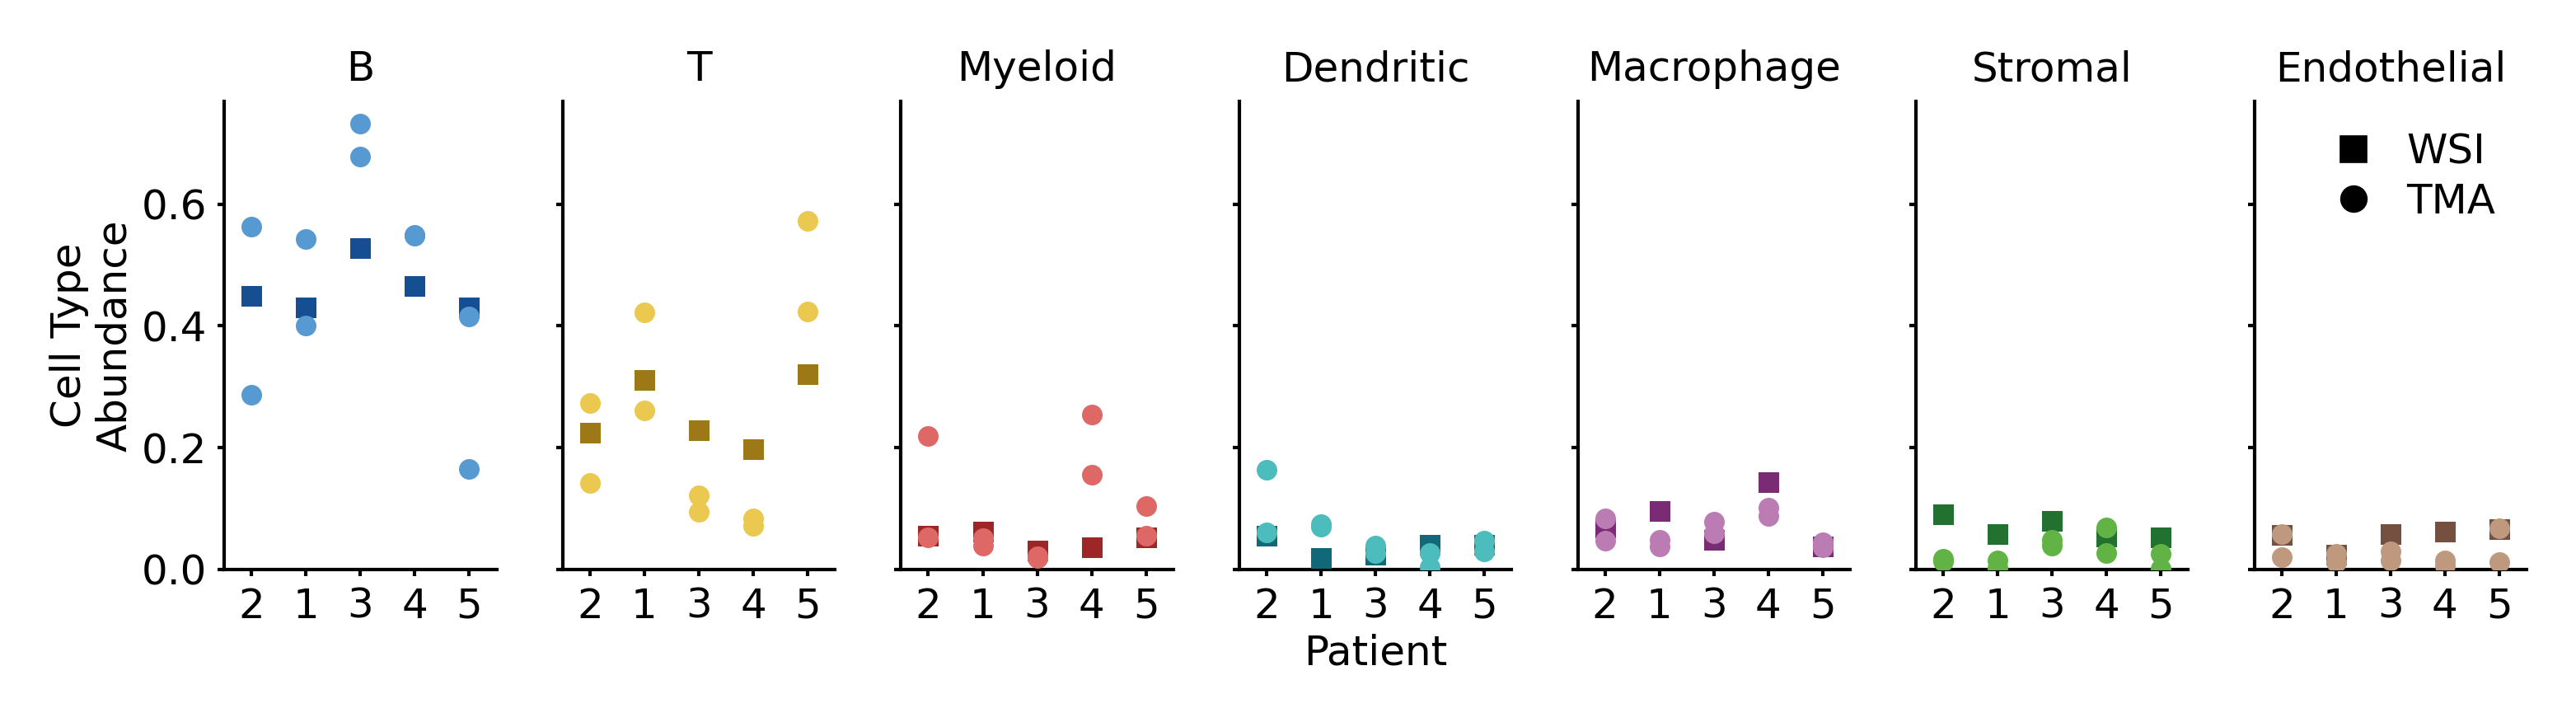

In [8]:
# TODO: SOMETHING IS STILL WRONG IN THE ORDER
patient_mapping = {'DLBCL_1': '2', 'DLBCL_2': '1', 'DLBCL_5': '3', 'DLBCL_3': '4', 'DLBCL_4': '5'}

color_dict_tmp = {'TMA - B cell': '#5799d1',
                  'WSI - B cell': '#154e91',
                  'TMA - T cell': '#ebc850',
                  'WSI - T cell': '#9c7817',
                  'TMA - Myeloid cell': '#de6866',
                  'WSI - Myeloid cell': '#9c2726',
                  'TMA - Dendritic cell': '#4cbcbd',
                  'WSI - Dendritic cell': '#106879',
                  'TMA - Macrophage': '#bb7cb4',
                  'WSI - Macrophage': '#792c73',
                  'TMA - Stromal cell': '#62b346',
                  'WSI - Stromal cell': '#237130',
                  'TMA - Endothelial cell': '#bf997d',
                  'WSI - Endothelial cell': '#754f40'}

def plot_wsi_tma_comparison(df, wsi_tma_map, celltype_colors, patient_mapping, font_size=6, point_size=3):
    """
    Plots a seaborn stripplot comparing WSI and corresponding TMAs for each cell type.
    
    Parameters:
    - df (pd.DataFrame): DataFrame with columns ['type', 'sample_id', 'cell_type', 'abundance'].
    - wsi_tma_map (dict): Dictionary mapping WSI sample_ids to lists of corresponding TMA sample_ids.
    - celltype_colors (dict): Dictionary mapping cell types to colors.
    - patient_mapping (dict): Dictionary mapping long sample IDs to short patient IDs (e.g., P1, P2, ...).
    - font_size (float): Font size for labels, legends, and titles.
    - point_size (float): Marker size for stripplot.
    """
    # Filter dataframe to keep only WSIs and their corresponding TMAs
    valid_sample_ids = set(wsi_tma_map.keys()) | {tma for tmas in wsi_tma_map.values() for tma in tmas}
    plot_df = df[df['sample_id'].isin(valid_sample_ids)].copy()
    plot_df['type_and_ct'] = [f"{row['type']} - {row['cell_type']}" for i, row in plot_df[['type', 'cell_type']].iterrows()]

    # Create a new column indicating the WSI group for both WSIs and their TMAs
    def map_to_wsi(sample_id):
        for wsi, tmas in wsi_tma_map.items():
            if sample_id == wsi or sample_id in tmas:
                return wsi
        return None

    plot_df['WSI_group'] = plot_df['sample_id'].apply(map_to_wsi)

    # Map sample IDs to patient labels (P1, P2, etc.)
    plot_df['WSI_group'] = plot_df['WSI_group'].map(patient_mapping)
    
    # Define markers for WSI and TMA
    markers = {'WSI': 's', 'TMA': 'o'}

    # Create FacetGrid with one subplot per cell type
    g = sns.FacetGrid(
        plot_df, 
        col="cell_type", 
        hue="type_and_ct", 
        palette=celltype_colors, 
        sharey=True, 
        aspect=0.5,
        height=1.5
    )
    
    g.fig.set_dpi(600)

    # Iterate over axes and plot WSI and TMA with different markers
    for ax, cell_type in zip(g.axes.flat, plot_df['cell_type'].unique()):
        subset = plot_df[plot_df['cell_type'] == cell_type]
        for sample_type in ['WSI', 'TMA']:
            sns.stripplot(
                data=subset[subset['type'] == sample_type],
                x='WSI_group',
                y='abundance',
                color=celltype_colors[f'{sample_type} - {cell_type}'],
                dodge=False,
                jitter=False,
                marker=markers[sample_type],
                size=point_size,
                ax=ax
            )

        # Set x-axis labels as patient IDs
        ax.set_xticklabels(list(patient_mapping.values()), fontsize=font_size)

        # Set tick font size
        ax.tick_params(axis='both', labelsize=font_size)


    # Set y-axis label and start at 0
    g.set_ylabels("Cell Type\nAbundance", fontsize=font_size)
    plt.ylim(0, None)

    # Identify the number of columns in the FacetGrid
    num_cols = len(g.axes.flat)

    # Determine the index of the middle plot
    middle_index = num_cols // 2  

    # Loop through axes to set title and x-label for only the middle plot
    for i, ax in enumerate(g.axes.flat):
        ax.set_title(ax.get_title(), fontsize=font_size)

        # Show xlabel only for the middle plot
        if i == middle_index:
            ax.set_xlabel("Patient", fontsize=font_size)
        else:
            ax.set_xlabel("")

    # Adjust tick font size
    for ax in g.axes.flat:
        ax.tick_params(axis='both', labelsize=font_size)
        title = ax.get_title()
        ax.set_title(title.replace("cell_type = ", "").replace(" cell", ""), fontsize=font_size)

    # Adjust layout
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.tight_layout()

    # Add a manual legend in the last plot
    last_ax = g.axes.flat[-1]
    legend_elements = [
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=5, label="WSI"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5, label="TMA"),
    ]
    last_ax.legend(handles=legend_elements, loc="upper right", frameon=False, fontsize=font_size)

    # Show plot
    plt.show()

# Example usage:
plot_wsi_tma_comparison(melted_df, wsi_tma_map, color_dict_tmp, patient_mapping)